In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Disponible GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Disponible GPU: []


In [2]:
# To display inline graphics in the notebook
%matplotlib inline

# Libraries for image and data manipulation
import cv2
import shutil
import math
import random
import numpy as np
import pandas as pd
from IPython.display import HTML
from base64 import b64encode

# Machine learning and deep learning libraries
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet50, InceptionResNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.model_selection import KFold, cross_val_score
from collections import deque
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# Data visualization libraries
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Libraries for file manipulation and time
import os
import h5py
from datetime import datetime
import pytz

# Libraries for evaluation metrics and data analysis
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
)
from tabulate import tabulate

# Other general libraries
from random import shuffle
import sys
import gc
keras.__version__

'2.10.0'

In [3]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/avi;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/avi"></video>' % src
    return HTML(html)

In [4]:
ViolnceVideos_Dir = r"C:\Users\arnab\anaconda3\Real Life Violence Dataset\Violence"
NonViolnceVideos_Dir=r"C:\Users\arnab\anaconda3\Real Life Violence Dataset\NonViolence"

In [5]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [6]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [7]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [8]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [10]:
DATASET_DIR=r"C:\Users\arnab\anaconda3\Real Life Violence Dataset"

In [15]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [16]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [17]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [18]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

features, labels, video_files_paths = create_dataset()
np.save(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/features.npy", features)
np.save(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/labels.npy", labels)
np.save(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence
Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [19]:
features, labels, video_files_paths = np.load(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/features.npy"), np.load(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/labels.npy"), np.load(r"C:\Users\arnab\anaconda3\Real Life Violence Dataset/video_files_paths.npy")

In [20]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [21]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [22]:
features_train_reshaped = features_train.reshape(features_train.shape[0], features_train.shape[1], -1)
features_test_reshaped = features_test.reshape(features_test.shape[0], features_test.shape[1], -1)

In [23]:
import tensorflow as tf

# Define the CNN model
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    return model

In [24]:
# Cell: Define the Multi-head Self-attention Block
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

In [25]:
# Cell: Define the Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [26]:
# Cell: Define the ViViT Model
def create_vivit_model(sequence_length, image_height, image_width, num_channels, num_classes, num_layers=8, num_heads=8, ff_dim=256):
    inputs = tf.keras.Input(shape=(sequence_length, image_height, image_width, num_channels))

    # CNN Feature Extractor
    cnn_model = create_cnn_model((image_height, image_width, num_channels))
    reshaped_inputs = tf.reshape(inputs, (-1, image_height, image_width, num_channels))
    cnn_features = cnn_model(reshaped_inputs)
    cnn_features = tf.reshape(cnn_features, (-1, sequence_length, cnn_features.shape[-1]))

    # Positional Encoding
    position_embedding = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=cnn_features.shape[-1])
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    encoded_positions = position_embedding(positions)
    x = cnn_features + encoded_positions

    # Transformer Encoder
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim=cnn_features.shape[-1], num_heads=num_heads, ff_dim=ff_dim)(x)

    # Classification Head
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

SEQUENCE_LENGTH = 16  # Example value
IMAGE_HEIGHT = 64    # Example value
IMAGE_WIDTH = 64     # Example value
NUM_CHANNELS = 3      # Example value
CLASSES_LIST = ["NonFight", "Fight"]  # Example classes

input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)
num_classes = len(CLASSES_LIST)
vivit_model = create_vivit_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_classes)
vivit_model.summary()

# IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
# SEQUENCE_LENGTH = 16

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 64, 64, 3)]   0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 64, 64, 3)         0         
                                                                 
 sequential (Sequential)     (None, 128)               93248     
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 16, 128)           0         
                                                                 
 tf.__operators__.add (TFOpL  (None, 16, 128)          0         
 ambda)                                                          
                                                                 
 transformer_block (Transfor  (None, 16, 128)          132480    
 merBlock)                                                   

In [28]:
# Cell: Compile the Model
vivit_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Cell: Train the Model
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

history = vivit_model.fit(
    features_train, labels_train,
    validation_data=(features_test, labels_test),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/50
225/225 [==============================] - 36s 129ms/step - loss: 0.7474 - accuracy: 0.5178 - val_loss: 0.6937 - val_accuracy: 0.4950
Epoch 2/50
225/225 [==============================] - 28s 125ms/step - loss: 0.7504 - accuracy: 0.5106 - val_loss: 0.6922 - val_accuracy: 0.5050
Epoch 3/50
225/225 [==============================] - 29s 127ms/step - loss: 0.7339 - accuracy: 0.5022 - val_loss: 0.6964 - val_accuracy: 0.5050
Epoch 4/50
225/225 [==============================] - 28s 127ms/step - loss: 0.7278 - accuracy: 0.4800 - val_loss: 0.6874 - val_accuracy: 0.5600
Epoch 5/50
225/225 [==============================] - 28s 125ms/step - loss: 0.7069 - accuracy: 0.5378 - val_loss: 0.6182 - val_accuracy: 0.6650
Epoch 6/50
225/225 [==============================] - 28s 122ms/step - loss: 0.6965 - accuracy: 0.5700 - val_loss: 0.6328 - val_accuracy: 0.6500
Epoch 7/50
225/225 [==============================] - 28s 125ms/step - loss: 0.6486 - accuracy: 0.6411 - val_loss: 0.6214 - val_ac

In [29]:
# Cell: Evaluate the Model
val_loss, val_acc = vivit_model.evaluate(features_test, labels_test)
print(f'Validation Accuracy: {val_acc:.2f}')

# Confusion matrix and classification report
y_pred = np.argmax(vivit_model.predict(features_test), axis=1)
y_true = np.argmax(labels_test, axis=1)
print(confusion_matrix(y_true, y_pred))
print(f'F1 Score: {f1_score(y_true, y_pred):.2f}')
print(f'Precision: {precision_score(y_true, y_pred):.2f}')
print(f'Recall: {recall_score(y_true, y_pred):.2f}')

7/7 [==============================] - 3s 124ms/step - loss: 0.2747 - accuracy: 0.8600
Validation Accuracy: 0.86
7/7 [==============================] - 3s 118ms/step
[[84 15]
 [13 88]]
F1 Score: 0.86
Precision: 0.85
Recall: 0.87


7/7 [==============================] - 1s 138ms/step


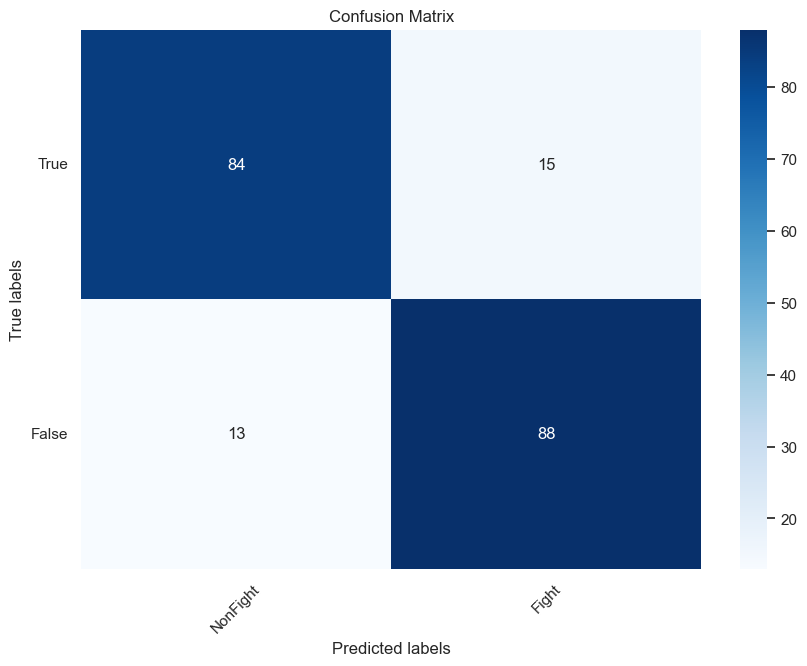

Accuracy: 0.86
F1 Score: 0.86
Precision: 0.86
Recall: 0.86


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# Assuming you have your test data and model ready
# y_pred contains the predicted labels
# y_true contains the true labels

# Get the predicted labels
y_pred = np.argmax(vivit_model.predict(features_test), axis=1)
y_true = np.argmax(labels_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the labels for the confusion matrix
class_names = ["NonFight", "Fight"]
true_labels = ["True", "False"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')

# Add labels to the plot
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(true_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Print additional metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Training Loss: 0.21
Training Accuracy: 0.92
Validation Loss: 0.34
Validation Accuracy: 0.83


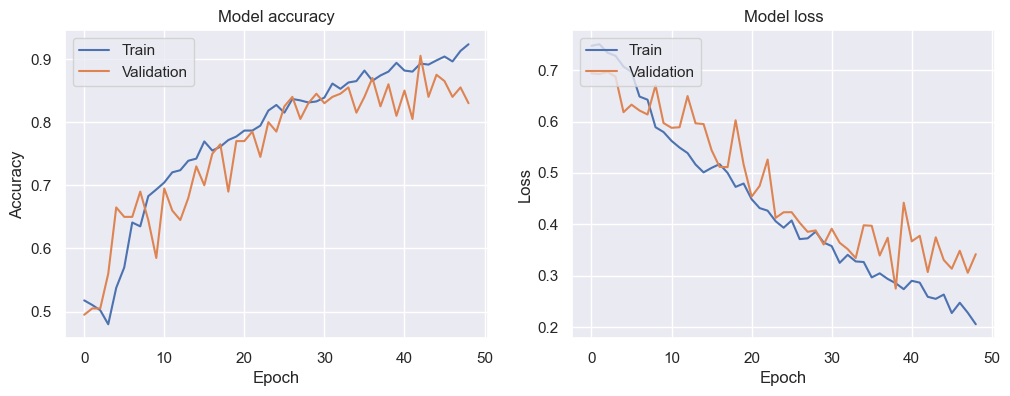

In [31]:
# Assuming the model has already been trained and the history object is available

# Get training and validation loss and accuracy from history object
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Print the training loss and accuracy for the last epoch
print(f"Training Loss: {training_loss[-1]:.2f}")
print(f"Training Accuracy: {training_accuracy[-1]:.2f}")

# Print the validation loss and accuracy for the last epoch
print(f"Validation Loss: {validation_loss[-1]:.2f}")
print(f"Validation Accuracy: {validation_accuracy[-1]:.2f}")

# Optionally, plot the training and validation loss and accuracy over epochs
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [32]:
!pip install tensorflow-addons

   ---------------------------------------- 0.0/729.9 kB ? eta -:--:--
    --------------------------------------- 10.2/729.9 kB ? eta -:--:--
   - ------------------------------------- 30.7/729.9 kB 660.6 kB/s eta 0:00:02
   --- ----------------------------------- 61.4/729.9 kB 469.7 kB/s eta 0:00:02
   ----- -------------------------------- 112.6/729.9 kB 726.2 kB/s eta 0:00:01
   ------- ------------------------------ 153.6/729.9 kB 706.2 kB/s eta 0:00:01
   ---------- --------------------------- 204.8/729.9 kB 831.5 kB/s eta 0:00:01
   -------------- ----------------------- 286.7/729.9 kB 930.9 kB/s eta 0:00:01
   ----------------- -------------------- 337.9/729.9 kB 952.6 kB/s eta 0:00:01
   -------------------- ----------------- 389.1/729.9 kB 969.0 kB/s eta 0:00:01
   -------------------------- ------------- 481.3/729.9 kB 1.1 MB/s eta 0:00:01
   -------------------------- ------------- 481.3/729.9 kB 1.1 MB/s eta 0:00:01
   ------------------------------------- -- 686.1/729.9 k

In [33]:
import tensorflow as tf
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to measure performance
def measure_performance(model, input_shape, num_samples=100):
    # Create random data to simulate the inputs
    dummy_input = tf.random.normal(input_shape)

    # Warm-up run
    model(dummy_input)

    # Measure inference time
    start_time = time.time()
    for _ in range(num_samples):
        model(dummy_input)
    total_time = time.time() - start_time
    inference_time = (total_time / num_samples) * 1000  # Inference time in milliseconds

    # Measure FPS (Frames Per Second)
    fps = num_samples / total_time

    # Measure FLOPs using tf.profiler
    concrete_func = tf.function(model).get_concrete_function(dummy_input)
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)

    return flops.total_float_ops, fps, inference_time

# Measure performance for ViViT model
input_shape_vivit = (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)  # Update with your actual input shape
flops_vivit, fps_vivit, inference_time_vivit = measure_performance(vivit_model, input_shape_vivit)

# Print ViViT model performance
print(f"ViViT Model FLOPs: {flops_vivit}")
print(f"ViViT Model FPS: {fps_vivit}")
print(f"ViViT Model Inference Time: {inference_time_vivit} ms")

# # Measure performance for MobiLSTM model
# input_shape_mobilstm = (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)  # Assuming input shape for MobiLSTM model
# flops_mobilstm, fps_mobilstm, inference_time_mobilstm = measure_performance(MoBiLSTM_model, input_shape_mobilstm)

# # Print MobiLSTM model performance
# print(f"MobiLSTM Model FLOPs: {flops_mobilstm}")
# print(f"MobiLSTM Model FPS: {fps_mobilstm}")
# print(f"MobiLSTM Model Inference Time: {inference_time_mobilstm} ms")

# Calculate metrics for ViViT model
y_pred_vivit = np.argmax(vivit_model.predict(features_test), axis=1)
accuracy_vivit = accuracy_score(y_true, y_pred_vivit)
precision_vivit = precision_score(y_true, y_pred_vivit, average="weighted")
recall_vivit = recall_score(y_true, y_pred_vivit, average="weighted")
f1_vivit = f1_score(y_true, y_pred_vivit, average="weighted")

# Print ViViT model metrics
print(f"ViViT Model Accuracy: {accuracy_vivit:.2f}")
print(f"ViViT Model Precision: {precision_vivit:.2f}")
print(f"ViViT Model Recall: {recall_vivit:.2f}")
print(f"ViViT Model F1-Score: {f1_vivit:.2f}")

# # Calculate metrics for MobiLSTM model
# y_pred_mobilstm = np.argmax(MoBiLSTM_model.predict(features_test), axis=1)
# accuracy_mobilstm = accuracy_score(y_true, y_pred_mobilstm)
# precision_mobilstm = precision_score(y_true, y_pred_mobilstm, average="weighted")
# recall_mobilstm = recall_score(y_true, y_pred_mobilstm, average="weighted")
# f1_mobilstm = f1_score(y_true, y_pred_mobilstm, average="weighted")

# # Print MobiLSTM model metrics
# print(f"MobiLSTM Model Accuracy: {accuracy_mobilstm:.2f}")
# print(f"MobiLSTM Model Precision: {precision_mobilstm:.2f}")
# print(f"MobiLSTM Model Recall: {recall_mobilstm:.2f}")
# print(f"MobiLSTM Model F1-Score: {f1_mobilstm:.2f}")

# Organize the performance metrics into a DataFrame
import pandas as pd
from tabulate import tabulate

data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "FLOPs", "FPS", "Inference Time (ms)"],
    "ViViT Model": [accuracy_vivit, precision_vivit, recall_vivit, f1_vivit, flops_vivit, fps_vivit, inference_time_vivit],
    # "MobiLSTM Model": [accuracy_mobilstm, precision_mobilstm, recall_mobilstm, f1_mobilstm, flops_mobilstm, fps_mobilstm, inference_time_mobilstm]
}

df = pd.DataFrame(data)
table = tabulate(df, headers="keys", tablefmt="pretty")
print(table)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
ViViT Model FLOPs: 983330828
ViViT Model FPS: 13.416862443015656
ViViT Model Inference Time: 74.53307390213013 ms
7/7 [==============================] - 1s 124ms/step
ViViT Model Accuracy: 0.86
ViViT Model Precision: 0.86
ViViT Model Recall: 0.86
ViViT Model F1-Score: 0.86
+---+---------------------+--------------------+
|   |       Metric        |    ViViT Model     |
+---+---------------------+--------------------+
| 0 |      Accuracy       |        0.86        |
| 1 |      Precision      | 0.8601161044940446 |
| 2 |       Recall        |        0.86        |
| 3 |      F1-Score       | 0.8599719887955182 |
| 4 |        FLOPs        |    983330828.0     |
| 5 |         FPS         | 13.416862443015656 |
| 6 | Inference Time (ms) | 74.53307390213013  |
+---+---------------------+--------------------+
